# Evoked EPSCs and IPSCs

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
# %load_ext autoreload
# %autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Evoked_PSCs" folder

In [2]:
data_folder = "data/7-Evoked_PSCs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/7-Evoked_PSCs


['data/7-Evoked_PSCs/2025_06_13_0008.abf',
 'data/7-Evoked_PSCs/2025_06_13_0020.abf',
 'data/7-Evoked_PSCs/2025_06_13_0021.abf',
 'data/7-Evoked_PSCs/2025_06_13_0022_100hz.abf',
 'data/7-Evoked_PSCs/2025_06_13_0019.abf',
 'data/7-Evoked_PSCs/2025_06_13_0018.abf',
 'data/7-Evoked_PSCs/2025_06_13_0023_100hz.abf',
 'data/7-Evoked_PSCs/2025_06_13_0016.abf',
 'data/7-Evoked_PSCs/2025_06_13_0017.abf',
 'data/7-Evoked_PSCs/2025_06_13_0015.abf',
 'data/7-Evoked_PSCs/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
# data_file = 'data/7-Evoked_PSCs/2025_06_13_0021.abf'
data_file = 'data/7-Evoked_PSCs/2025_06_13_0019.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_13_0019.abf')
Number of sweeps: 10
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


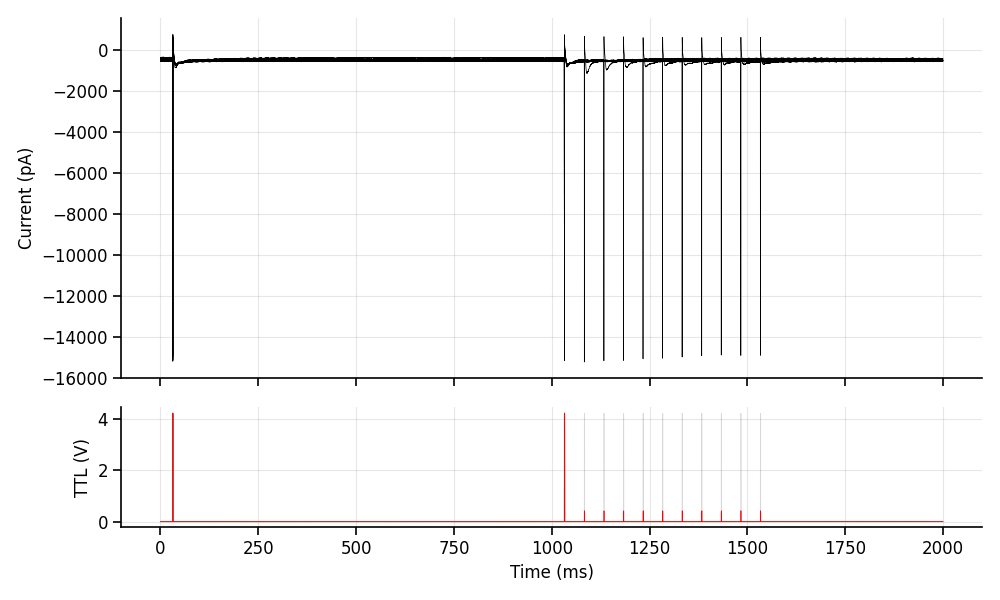

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

traces.plot(plot_ttl=True, plot_voltage=False, sweep='all', time_units=time_units)
# ax1,ax2 = traces.plot(plot_ttl=False, plot_voltage=False, sweep='all', time_units='ms')
# ax1.set_xlim(20,50)
plt.show()

## 2. Signal processing

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [5]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [-375.5493 -422.2137 -473.9227 ... -538.1683 -544.9036 -556.6772]
Baseline voltages: [-1392.6726 -1392.7025 -1392.8209 ... -1392.9515 -1392.8917 -1392.9747]


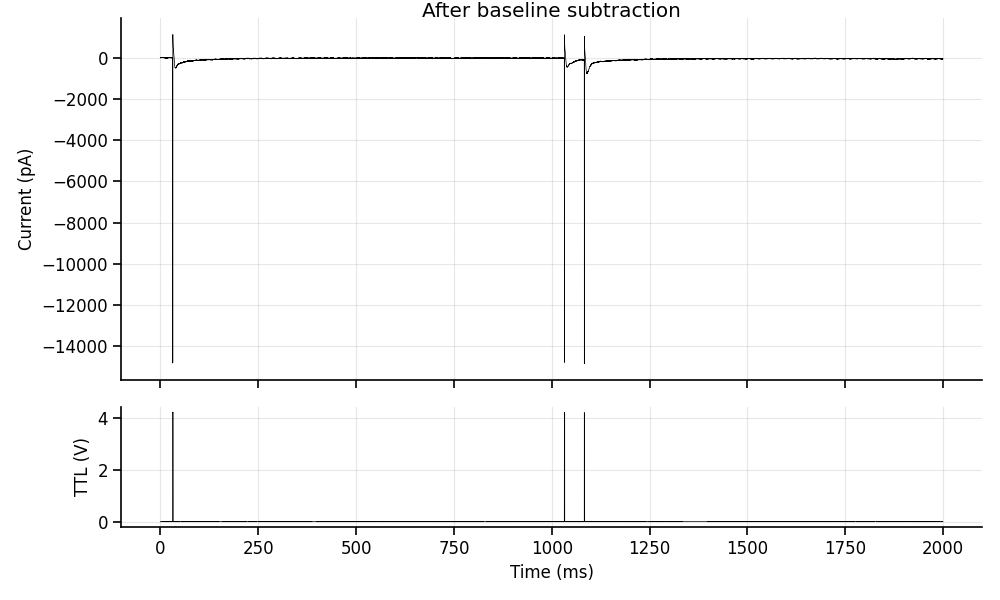

In [6]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 20, 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'all')  # Options: 'current', 'voltage', 'all'
    ax1, ax2 = traces.plot(plot_voltage=False, plot_ttl=True, time_units=time_units)
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [7]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = True

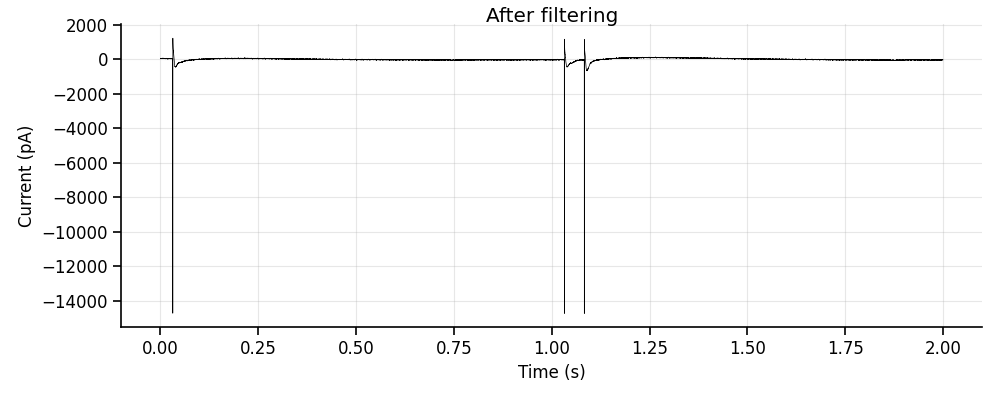

In [8]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=0.5,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.5,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=4900,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.


    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [9]:
if additional_filtering:
    traces=filtered_traces

## 3. Measure EPSCs/IPSCs to get paired pulse ratio

(If you want to save images, click on the save icon on the left when you hover over the image)

### 3.1. Get the single-stim response


In [10]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=-2000, 
                                    polarity='negative', 
                                    time_units=time_units, 
                                    channel='current', sweep='all')
print(f"Stim times:")
stim_times

Stim times:


[array([  31.4, 1032.4, 1083.4]),
 array([  31.4, 1032.4, 1133.4]),
 array([  31.4, 1032.4, 1183.4]),
 array([  31.4, 1032.4, 1233.4]),
 array([  31.4, 1032.4, 1283.4]),
 array([  31.4, 1032.4, 1333.4]),
 array([  31.4, 1032.4, 1383.4]),
 array([  31.4, 1032.4, 1433.4]),
 array([  31.4, 1032.4, 1483.4]),
 array([  31.4, 1032.4, 1533.4])]

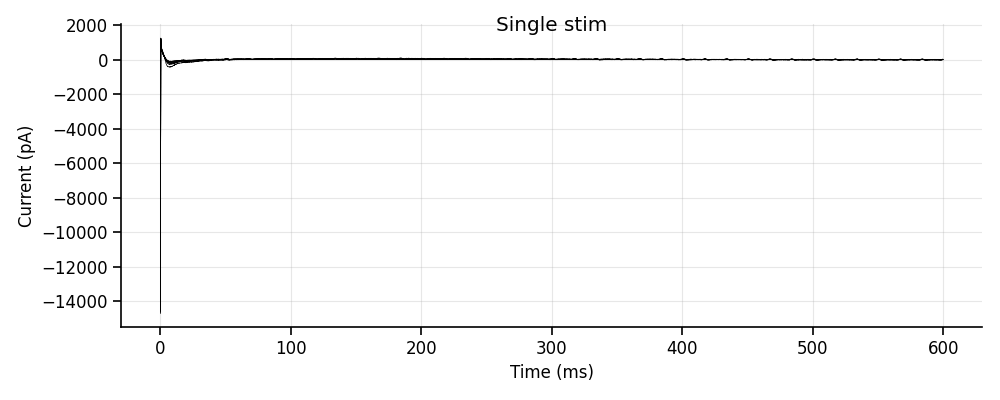

In [11]:
window_size = 600 #ms

single_stim_traces = traces.crop(timepoint=stim_times[0][0], window=window_size, time_units=time_units)
ax = single_stim_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('Single stim',y=0.95)
plt.show()

#### Optional: remove bad traces

In [12]:
remove_spikes = False

# ---------------------------------------------------------------------------------------------------------
if remove_spikes:
    # Remove sweeps with positive current spikes above or below threshold
    info = single_stim_traces.remove_sweeps_with_spikes(threshold=-2000, polarity='negative', 
                                                channel='current', return_info=True)

    ax = single_stim_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
    # ax.set_ylim(bottom=-600, top=100)
    ax.set_title('Single stim (spikes removed)',y=0.95)
    plt.show()

#### Measure single-stim amplitudes

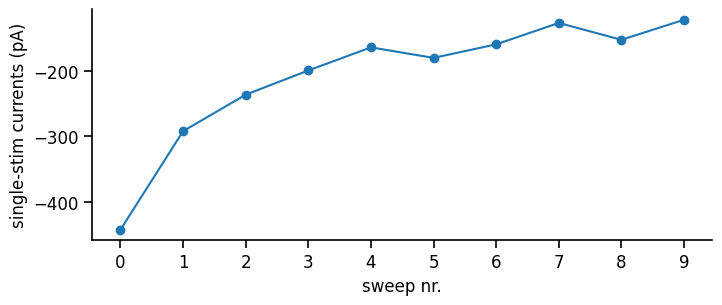

In [ ]:
single_stim_currents, _ = single_stim_traces.get_measurements(start_time=4, 
                                                            end_time=15, 
                                                            measurement_type='min', 
                                                            time_units=time_units)
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(single_stim_currents))
ax.plot(x, single_stim_currents, '-o')
ax.set_ylabel('Single-stim currents (pA)')
ax.set_xlabel("Sweep nr.")
plt.show()

### 3.2. Get the response to the first paired-pulse stim

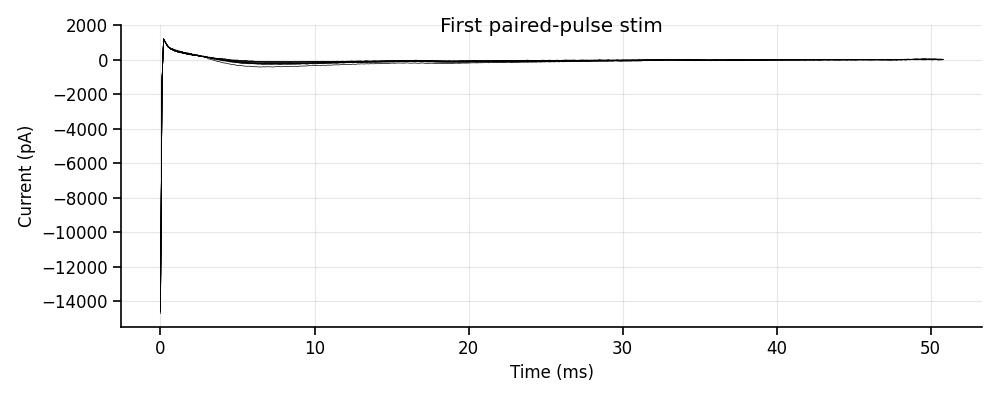

In [14]:
smallest_interval = stim_times[0][2] - stim_times[0][1]
first_pulse_traces = traces.crop(timepoint=stim_times[0][1], window=smallest_interval, time_units=time_units)
%matplotlib widget
ax = first_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('First paired-pulse stim',y=0.95)
plt.show()

#### Optional: remove bad traces

In [15]:
remove_spikes = False

# ---------------------------------------------------------------------------------------------------------
if remove_spikes:
    # Remove sweeps with positive current spikes above or below threshold
    info = first_pulse_traces.remove_sweeps_with_spikes(threshold=-2000, polarity='negative', 
                                                channel='current', return_info=True)
    ax = first_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
    # ax.set_ylim(bottom=-600, top=100)
    ax.set_title('First paired-pulse stim (spikes removed)',y=0.95)
    plt.show()

#### Measure first paired-pulse amplitudes

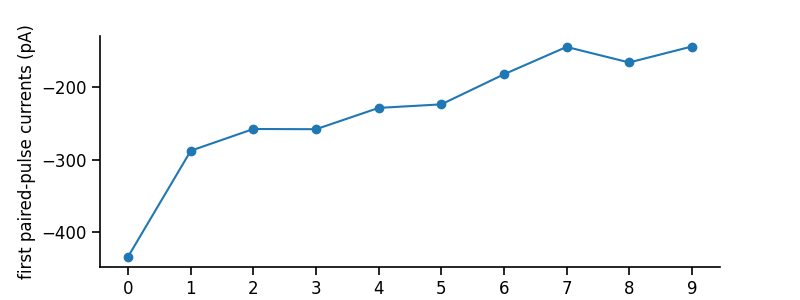

In [16]:
first_pulse_currents,_ = first_pulse_traces.get_measurements(start_time=2, 
                                                            end_time=15, 
                                                            measurement_type='min', 
                                                            time_units=time_units)
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(first_pulse_currents, '-o')
ax.set_xticks(range(len(first_pulse_currents)))
ax.set_ylabel('first paired-pulse currents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.3. Get the response to the second paired-pulse stim

#### Subtract single-stim response from paired-pulse trace

This allows us to recover the shape/amplitude of the second pulse, without the contribution of the first pulse

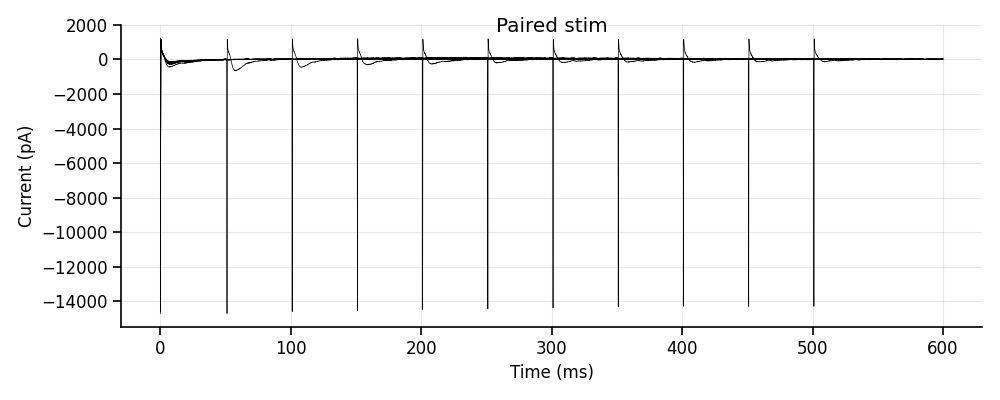

In [17]:
paired_pulse_traces = traces.crop(timepoint=stim_times[0][1], window=window_size, time_units='ms')
ax = paired_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('Paired stim',y=0.95)
plt.show()

Now we will get the average "first stim" response and subtract it from all of the paired-pulse sweeps

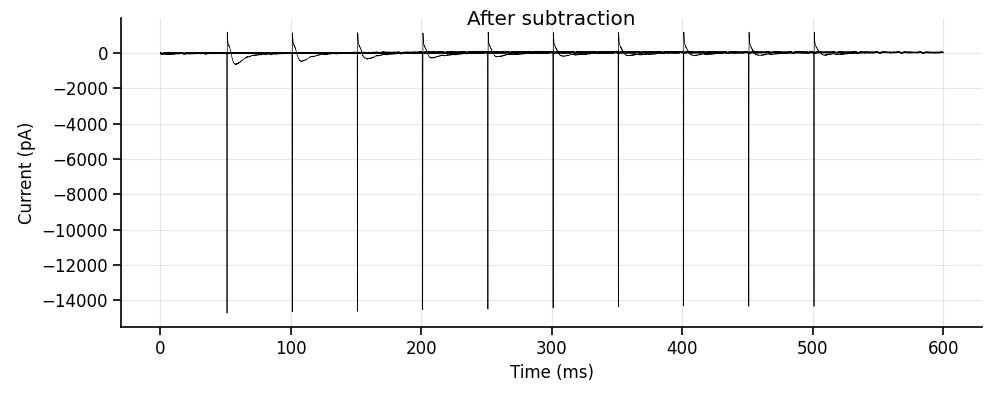

In [18]:
subtracted_traces = paired_pulse_traces.copy()
subtract_average_single_stim = False  # We can either subtract the average single-stim, or subtract each individual single-stim (from every sweep)

if subtract_average_single_stim:
    avg_single_stim_trace = np.mean(single_stim_traces.current_data, axis=0)
    len1 = avg_single_stim_trace.shape[0]
    len2 = subtracted_traces.current_data.shape[1]
    if len1<len2:
        subtracted_traces.current_data = subtracted_traces.current_data[:,:len1]
    elif len2<len1:
        avg_single_stim_trace = avg_single_stim_trace[:len2]
    subtracted_traces.current_data -= avg_single_stim_trace
else:
    len1 = single_stim_traces.current_data.shape[1]
    len2 = subtracted_traces.current_data.shape[1]
    if len1<len2:
        subtracted_traces.current_data = subtracted_traces.current_data[:,:len1]
    elif len2<len1:
        avg_single_stim_trace = avg_single_stim_trace[:,:len2]
    subtracted_traces.current_data -= single_stim_traces.current_data

ax = subtracted_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('After subtraction',y=0.95)
plt.show()

Now we need to isolate the second pulse


In [19]:
# Find positive current peaks above threshold
stim_times = subtracted_traces.get_event_times(threshold=-2000, 
                                            polarity='negative', 
                                            time_units=time_units, 
                                            channel='current', sweep='all')
print(f"Stim times:")
stim_times

Stim times:


[array([51.]),
 array([101.]),
 array([151.]),
 array([201.]),
 array([251.]),
 array([301.]),
 array([351.]),
 array([401.]),
 array([451.]),
 array([501.])]

#### Measure second paired-pulse amplitudes

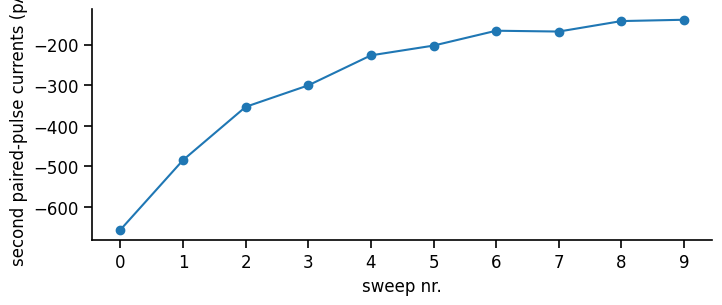

In [ ]:
second_pulse_currents = []
for i, stim_time in enumerate(stim_times):
    current,_ = subtracted_traces.get_measurements(sweep=i, measurement_type='min', time_units=time_units,
                                                   start_time=stim_time+2, end_time=stim_time+15)
    second_pulse_currents.append(current)

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(second_pulse_currents))
ax.plot(x, second_pulse_currents, '-o')
ax.set_ylabel('Second paired-pulse \ncurrents (pA)')
ax.set_xlabel("Sweep nr.")
plt.show()

### 3.4. Plot paired-pulse ratio

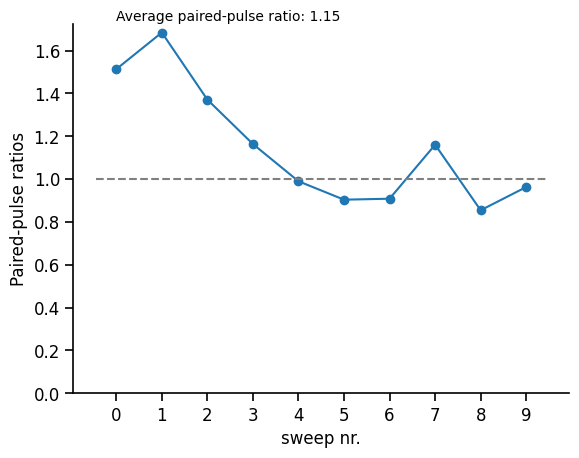

In [ ]:
if len(first_pulse_currents) == len(second_pulse_currents):
    paired_pulse_ratios = second_pulse_currents / first_pulse_currents
    avg_ppr = np.mean(paired_pulse_ratios)
    fig,ax = plt.subplots()
    ax.plot(paired_pulse_ratios, '-o')
    ax.set_xticks(range(len(second_pulse_currents)))
    xlims = ax.get_xlim()
    ax.set_ylim(bottom=0)
    ylims = ax.get_ylim()
    ax.hlines(1, xlims[0],xlims[1],linestyle='--',color='gray')
    ax.text(0, ylims[1], f"Average paired-pulse ratio: {avg_ppr:.2f}", fontsize=10, ha='left', va='bottom')
    ax.set_ylabel('Paired-pulse ratio \n(EPSC 1 / EPSC 2)')
    ax.set_xlabel("sweep nr.")
    plt.show()
else:
    avg_second_pulse = np.mean(second_pulse_currents)
    avg_first_pulse = np.mean(first_pulse_currents)
    paired_pulse_ratio = avg_second_pulse / avg_first_pulse
    print(f"Paired-pulse ratio: {paired_pulse_ratio}")
